In [1]:
import pandas as pd
import numpy as np
import os
import random

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import torch
import numpy as np
from collections import Counter
import pickle as pkl


import numpy as np
import torch
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.nn.functional as F



In [4]:
## Load the targets

train_targets = pd.read_csv("train_targets.csv").iloc[:,0].tolist()
val_targets = pd.read_csv("val_targets.csv").iloc[:,0].tolist()
test_targets = pd.read_csv("test_targets.csv").iloc[:,0].tolist()


In [5]:

# Then, load preprocessed train, val and test datasets
train_data_tokens = pkl.load(open("train_data_tokens_1.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens_1.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens_1.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens_1.p", "rb"))

# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 4827321


In [6]:

max_vocab_size = 7000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens)

In [7]:
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 5425 ; token visions
Token visions; token id 5425


In [8]:
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [9]:
MAX_SENTENCE_LENGTH = 200


class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]


BATCH_SIZE = 85
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)



In [10]:
# First import torch related libraries

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

emb_dim = 20
model = BagOfWords(len(id2token), emb_dim)

In [16]:
learning_rate = 0.002
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

accs=[]
Losses=[]
for epoch in range(num_epochs):
    epoch_loss=[]
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        epoch_loss.append(loss)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    
    Losses.append(sum(epoch_loss))
    accs.append(val_acc)

Epoch: [1/10], Step: [101/236], Validation Acc: 85.98
Epoch: [1/10], Step: [201/236], Validation Acc: 86.08
Epoch: [2/10], Step: [101/236], Validation Acc: 86.5
Epoch: [2/10], Step: [201/236], Validation Acc: 86.44
Epoch: [3/10], Step: [101/236], Validation Acc: 86.68
Epoch: [3/10], Step: [201/236], Validation Acc: 86.18
Epoch: [4/10], Step: [101/236], Validation Acc: 86.28
Epoch: [4/10], Step: [201/236], Validation Acc: 86.52
Epoch: [5/10], Step: [101/236], Validation Acc: 86.3
Epoch: [5/10], Step: [201/236], Validation Acc: 86.46
Epoch: [6/10], Step: [101/236], Validation Acc: 86.5
Epoch: [6/10], Step: [201/236], Validation Acc: 86.68
Epoch: [7/10], Step: [101/236], Validation Acc: 86.54
Epoch: [7/10], Step: [201/236], Validation Acc: 86.46
Epoch: [8/10], Step: [101/236], Validation Acc: 86.46
Epoch: [8/10], Step: [201/236], Validation Acc: 86.58
Epoch: [9/10], Step: [101/236], Validation Acc: 86.52
Epoch: [9/10], Step: [201/236], Validation Acc: 86.24
Epoch: [10/10], Step: [101/236]

In [17]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))

After training for 10 epochs
Val Acc 86.12
Test Acc 93.096


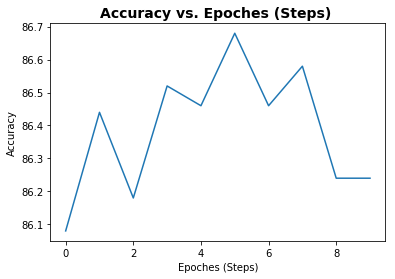

In [18]:
# Plot the Validation Accuracy of Learning curves 
fig, ax = plt.subplots()
ax.plot(accs) 
ax.set_xlabel('Epoches (Steps)')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs. Epoches (Steps) ', loc='center', fontsize=14, fontweight = "bold") 
fig.savefig("Learning_curves.png", bbox_inches = "tight", dip = 1200)

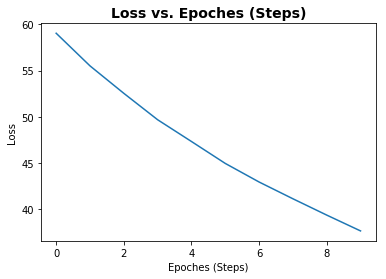

In [19]:

# Plot the Training Loss of Learning curves 
fig, ax = plt.subplots()
ax.plot(Losses) 
ax.set_xlabel('Epoches (Steps)')
ax.set_ylabel('Loss')
ax.set_title('Loss vs. Epoches (Steps)', loc='center', fontsize=14, fontweight = "bold") 
fig.savefig("Learning_curves_Training_Loss.png", bbox_inches = "tight", dip = 1200)

---
### Output the correct and incorrect predictions 

In [12]:
# Not very sophisticated codes and only for one time use.
correct = 0
incorrect = 0
total = 0
model.eval()
for data, lengths, labels in val_loader:
    
    data_batch, length_batch, label_batch = data, lengths, labels
    outputs = F.softmax(model(data_batch, length_batch), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
        
    total += labels.size(0)
    correct += predicted.eq(labels.view_as(predicted)).sum().item()
    
    if total >=1:
        break
        

In [13]:
correct_index = np.argwhere((predicted.numpy()-labels.numpy().reshape(85,1))==0)[0:3,0]
incorrect_index = np.argwhere((predicted.numpy()-labels.numpy().reshape(85,1))!=0)[0:3,0]
    

In [21]:
print("the corrected results")
for i in correct_index:
    print("Predicted Label {} and actual label {}".format(predicted.numpy()[i],labels.numpy()[i]))
    print ("\n")
    print (' '.join(val_data_tokens[i]))
    print ("\n")

the corrected results
Predicted Label [1] and actual label 1


this is a good example a film that in spite of the low rating is more than worth watching the story is engaging and it does n't take long before the chemistry between nicole kidman and ben chaplin grabs your attention the acting is first class and the characters are represented well sometimes it feels like the director could n't decide himself between drama and romantic comedy ben chiller 's portrayal of the law abiding and shy englishman with porn s.m. magazines hidden in the bedroom creates plenty of moments for laughs as does the look in nicole kidman 's eyes when she is offering john his first taste of intimacy in a long time ... other times the actors and especially nicole kidman give this comedy quite expertly a dramatic slant


Predicted Label [0] and actual label 0


this movie is bad it 's basically an overdone copy of michael jackson 's thriller video only worse the special effects consist of lots of glow in the d

In [20]:
print("the incorrected results")
for i in incorrect_index:
    print("Predicted Label {} and actual label {}".format(predicted.numpy()[i],labels.numpy()[i]))
    print ("\n")
    print (' '.join(val_data_tokens[i]))
    print ("\n")

the incorrected results
Predicted Label [1] and actual label 0
first before reading further you must understand that i 'm not neo nazi i 'm just trying to understand correctly hitler to be sure nobody like him take power again.<br /><br />i've seen this series and found it awful i mean ok it 's interesting to look but is it real i searched for answers and found one absolutely not first hitler was n't angry all his life the series shows an angry hitler even when he is a child second hitler never wanted to abuse his daughter in fact it is highly probable that hitler in reality was gay and fought all his life to choke this secret third people will hate me but it 's true hitler was charming how do you think he managed to get to power if he was so hateful and ugly because he was charming that 's a common point i found in the interviews of people who live near or far of him of course not jews).<br /><br />this series was awful because if you think that hitler was just an angry bastard ugly a